In [2]:
# math, numpy and torch
import math
import numpy as np
import torch

#SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# SciPy
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Constants
torch.manual_seed(0)
np.random.seed(0)
tf = 60
dt = 0.01
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

In [4]:
# IFFL params
k1, k2, k3, k4, Ac, xi = 1, 1, 0, 0.2, 1, 0.1

def system(t, z, k1, k2, k3, k4, Ac, xi):
    """
    This function returns the ODE system.

    Args:
        t (paramter): time (optional)
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    x, y = z
    return [- k1*x - k2*y + Ac, k3*x - k4*y + xi*Ac]

def simulator(k1, k2, k3, k4, Ac, xi):
    """Solves the ODE system using the SciPy solver.

    Args:
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant

    Returns:
        The solution of the ODE system.
    """
    return solve_ivp(system, tspan, c0, args = (k1, k2, k3, k4, Ac, xi), t_eval = t) # Paso explicito

In [5]:
# true parameters and respective labels
true_params = np.array([k1, k2, k3, k4, Ac, xi])
labels_params = [r"$k_{1}$", r"$k_{2}$", r"$k_{3}$", r"$k_{4}$", r"$A_{c}$", r"$A_{s}$", r"$\xi$"]

observation_trace = simulator(true_params[0], true_params[1], true_params[2], true_params[3], true_params[4], true_params[5])

def calculate_summary_statistics(x, y, dt):
    """Calculates the summary statistics (attributes) of the system.

    Args:
        x (array): The system state variable.

    Returns:
        A numpy array with the summary statistics (attributes) of the system
    """
    
    if np.any(x < 0): # Not a valid simulation
        return np.array([math.nan, math.nan, math.nan, math.nan, math.nan, math.nan])
    else:
        # Check if the system presents oscillations
        peaks, _ = find_peaks(x, height=0.1, prominence=0.1)
        if len(peaks) > 1:
            # The system has oscillations
            return np.array([math.nan, math.nan, math.nan, math.nan, math.nan, math.nan])
        
        # Peak
        # I don't want to use find_peaks for this since I have the min height and min prominence
        Xpeak = np.max(x)
        Tpeak = np.where(x == Xpeak)[0][0] * dt
        
        tau1 = np.where(x >= Xpeak*0.63)[0][0] * dt
        
        # Check that if the last value of x is close to the last five second value in the tolerance
        # If it is, then the system has (probably) reached the steady state
        tol = Xpeak * 1e-1
        if np.isclose(x[-1], x[int(-5/dt)], atol=tol): # five second
            x_ss = x[-1]
        else:
            x_ss = math.nan
        
        tol = 1e-5
        tau2_index = np.where(np.isclose(x, x_ss + (Xpeak - x_ss)*0.37, atol=tol))
        
        # Grab first index where tau2 * dt is greater than Tpeak
        tol_tau2 = 1e-2;
        try:
            tau2_index = tau2_index[0][tau2_index[0] > Tpeak/dt][0]
            tau2 = tau2_index*dt
            if Xpeak < x_ss+tol_tau2 and Xpeak > x_ss-tol_tau2 or math.isnan(tau2): # This is if there isn't a peak, therefor no tau2
                tau2 = math.nan
        except:
            tau2 = math.nan
            
        y_fin = y[-1]
        
        Ypeak = np.max(y)
        tau1_Y = np.where(y >= Ypeak*0.63)[0][0] * dt
        
        return np.array([tau1, tau2, x_ss, Xpeak, y_fin, tau1_Y])

observation_summary_statistics = calculate_summary_statistics(observation_trace.y[0], observation_trace.y[1]) #y[0] = x, y[1] = y

Tau 1, Tau 2, Xss, Xpeak, Y_fin, Tau 1 Y
[0.728      8.386      0.49966464 0.78861887 0.49999692 4.972     ]


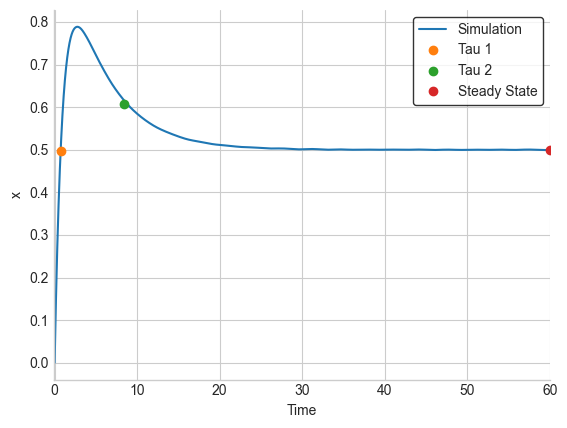

In [6]:
k1, k2, k3, k4, Ac, xi = 1, 1, 0, 0.2, 1, 0.1

# Plot ODE +  Stats
sol = simulator(k1, k2, k3, k4, Ac, xi)
plt.plot(sol.t, sol.y[0], label="Simulation")

stats = calculate_summary_statistics(sol.y[0], sol.y[1])
print("Tau 1, Tau 2, Xss, Xpeak, Y_fin, Tau 1 Y")
print(stats)

# If we return Xpeak:
try:
    plt.plot(stats[0], stats[3]*0.63, 'o', label="Tau 1", markersize=6)
    plt.plot(stats[1], stats[2] + (stats[3] - stats[2])*0.37, 'o', label="Tau 2", markersize=6)
except:
    pass

plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.plot(tf, stats[2], 'o', label="Steady State", markersize=6)
plt.legend(frameon=True, facecolor="white", edgecolor="black")
plt.show()

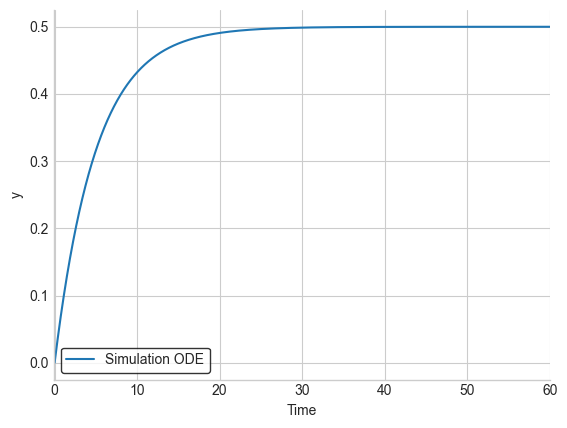

In [7]:
# Plot ODE (y)
sol_true = simulator(k1, k2, k3, k4, Ac, xi)
plt.plot(sol.t, sol_true.y[1], label="Simulation ODE")
plt.xlabel('Time')
plt.ylabel('y')
plt.xlim(0-0.1, tf)
plt.legend(frameon=True, facecolor="white", edgecolor="black")
plt.show()

In [8]:
def simulation_wrapper(params):
    """
    Returns summary statistics from the model results using `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    obs = simulator(params[0], params[1], params[2], params[3], params[4], params[5]) #y[0] = x
    stats = torch.as_tensor(calculate_summary_statistics(obs.y[0], obs.y[1]))
    return stats

In [9]:
# num_dim = 6;

prior_min = [0, 0, 0, 0, 0, 0]
prior_max = [2, 2, 0.5, 0.5, 2, 1]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

#prior = utils.BoxUniform(low = 0*torch.ones(num_dim), high = 2*torch.ones(num_dim))

# A infer hay que pasarle el wrapper del simulator, no el simulator
posterior = infer(simulation_wrapper, prior, method="SNPE", num_simulations=200000, num_workers=4) # paralellizable, do NOT use Python 3.11

Running 200000 simulations in 200000 batches.:   0%|          | 0/200000 [00:00<?, ?it/s]

 Neural network successfully converged after 190 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

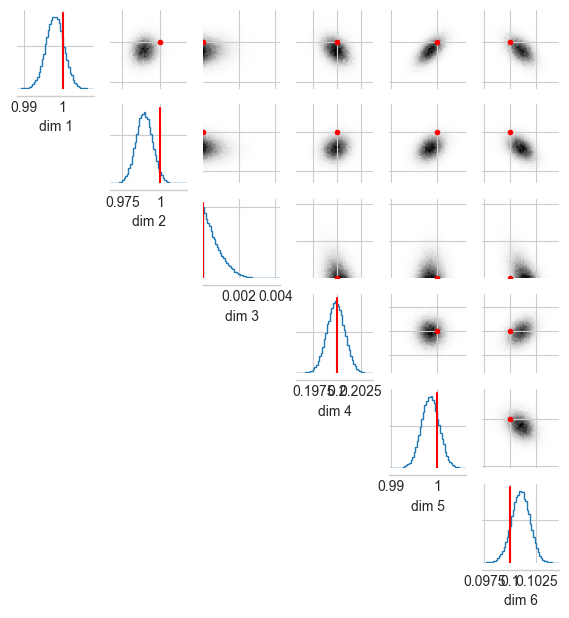

In [10]:
samples = posterior.sample((50000,), x=observation_summary_statistics)

fig, axes = analysis.pairplot(
    samples,
    figsize=(7, 7),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

 --- Real parameters --- 
1 1 0 0.2 1 0.1
 --- Parameters estimated --- 
[[9.9925900e-01 9.9344808e-01 7.6934602e-04 2.0001180e-01 9.9501187e-01
  1.0109319e-01]]
 --- Tau 1, Tau 2, X steady state, X peak, Y_10000, Y_fin, Tau 1 Y --- 
tensor([0.7270, 8.3600, 0.4935, 0.7839, 0.5048, 4.9580], dtype=torch.float64)
[0.728      8.386      0.49966464 0.78861887 0.49999692 4.972     ]


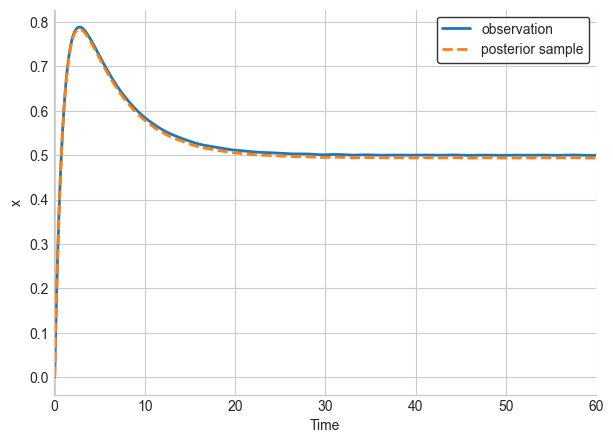

In [14]:
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()
fig = plt.figure(figsize=(7, 5))

# Plot observation
t = observation_trace.t
y_obs = observation_trace.y[0]
plt.plot(t, y_obs, lw=2, label="observation")
print(" --- Real parameters --- ")
print(k1, k2, k3, k4, Ac, xi)
print(" --- Estimated Parameters --- ")
print(posterior_sample)
print(" --- Real attributes --- ")
print(observation_summary_statistics)
print(" --- Estimated attributes --- ")
print(simulation_wrapper(posterior_sample[0]))

# Simulate and plot samples from the posterior
x = simulator(posterior_sample[0][0], posterior_sample[0][1], posterior_sample[0][2], posterior_sample[0][3], posterior_sample[0][4], posterior_sample[0][5])
plt.plot(x.t, x.y[0], "--", lw=2, label="posterior sample")

plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)

plt.legend(frameon=True, facecolor="white", edgecolor="black")

plt.xlabel("Time")
plt.ylabel("x")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

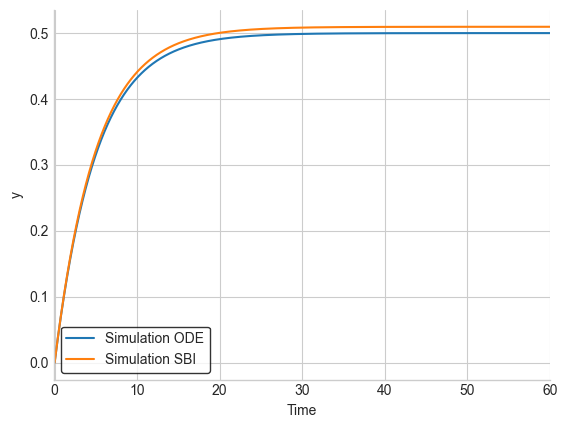

In [12]:
# Plot ODE (y)
sol = simulator(posterior_sample[0][0], posterior_sample[0][1], posterior_sample[0][2], posterior_sample[0][3], posterior_sample[0][4], posterior_sample[0][5])
sol_true = simulator(k1, k2, k3, k4, Ac, xi)
plt.plot(sol.t, sol_true.y[1], label="Simulation ODE")
plt.plot(sol.t, sol.y[1], label="Simulation SBI")

plt.xlabel('Time')
plt.ylabel('y')
plt.xlim(0-0.1, tf)
plt.legend(frameon=True, facecolor="white", edgecolor="black")
plt.show()

In [13]:
import dill
dill.dump_session('notebook_sbi_iffl_200k_noY10000.db')